# 대기 습도와 미세먼지 사이의 관계를 데이터로 보기
- 가습기와 공기청정기를 동시에 틀었을 때, 공기 청정기가 팡팡 돌아가는 것을 보면서 들었던 궁금증이다.
1. 습도가 높아지면 미세먼지 농도가 높아질까?
2. 아니면 공기 중의 수분이 미세먼지를 잡아서 미세먼지 농도를 낮출까?

## 배경 지식을 알기 전에, 2022년 서울시의 습도와 미세먼지 농도를 살펴보자
- 데이터 출처 
- [습도 데이터](https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do)
- [미세먼지 데이터]()

In [70]:
import pandas as pd
import chardet # 파일의 인코딩을 자동으로 감지해줌 : GPT 무섭다 ㄹㅇ

with open('2022_humidity.csv', 'rb') as f:
    result = chardet.detect(f.read())
# result : {'encoding': 'EUC-KR', 'confidence': 0.99, 'language': 'Korean'}
    
humidity = pd.read_csv('2022_humidity.csv', 
                       encoding = result['encoding'],
                      )

# 둘다 'EUC-KR'인데, 2번째로 chardet을 실행하면 루프에 빠지는 듯?


particle = pd.read_csv('2022_particle.csv', 
                       encoding = result['encoding'])

display(humidity.head(5))
particle.head(5)

,\t\t지점번호,지점명,일시,평균습도(%rh),최저습도(%rh)
0,108,서울,2022-01-01,46.3,31.0
1,108,서울,2022-01-02,57.9,39.0
2,108,서울,2022-01-03,58.3,35.0
3,108,서울,2022-01-04,51.8,28.0
4,108,서울,2022-01-05,47.6,34.0


,일시,구분,미세먼지(PM10),초미세먼지(PM2.5)
0,2022-12-31 23:00,평균,59.0,46.0
1,2022-12-31 23:00,강남구,57.0,44.0
2,2022-12-31 23:00,강동구,68.0,55.0
3,2022-12-31 23:00,강북구,59.0,42.0
4,2022-12-31 23:00,강서구,62.0,40.0


### `humidty` 수정 내용
1. `지점번호, 지점명` column 제거
2. `일시` column 시계열 데이터로 변경

In [71]:
humidity = humidity.drop(['\t\t지점번호', '지점명'], axis = 1)
humidity.sample(5)
humidity['일시'] = pd.to_datetime(humidity['일시'])

In [72]:
humidity.head(2)

,일시,평균습도(%rh),최저습도(%rh)
0,2022-01-01,46.3,31.0
1,2022-01-02,57.9,39.0


### `particle` 수정 내용
1. 각 시간과 지역 별로 구분되어 있음 -> 구분에서 "평균"만 취한다
2. 시간들도 통합한다 : 전체 시간의 평균 값을 취함

In [74]:
particle = particle[particle['구분'] == '평균'][:]
particle['일시'] = (pd.to_datetime(particle['일시']).dt
                                                    .date # 이거 결과가 의외로 object다.
                                                    .astype('datetime64')    
                 ) 
particle = (particle.groupby('일시')
         .mean(['미세먼지(PM10)', '초미세먼지(PM2.5)'])
         .reset_index()
         .set_index('일시')
)


In [75]:
particle = particle.rename(columns = {'미세먼지(PM10)' : 'PM10', '초미세먼지(PM2.5)' : 'PM2.5'})
particle = particle[['PM10', 'PM2.5']].apply(lambda x : round(x, 0))
particle.head()

,PM10,PM2.5
일시,,
2022-01-01,27.0,15.0
2022-01-02,35.0,23.0
2022-01-03,25.0,15.0
2022-01-04,34.0,20.0
2022-01-05,48.0,29.0


## 두 df 합치기

In [78]:
df = pd.merge(humidity, particle, on = '일시')
df.head()

,일시,평균습도(%rh),최저습도(%rh),PM10,PM2.5
0,2022-01-01,46.3,31.0,27.0,15.0
1,2022-01-02,57.9,39.0,35.0,23.0
2,2022-01-03,58.3,35.0,25.0,15.0
3,2022-01-04,51.8,28.0,34.0,20.0
4,2022-01-05,47.6,34.0,48.0,29.0


In [82]:
df.info()
df.to_csv('2022_hum_particle.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일시         365 non-null    datetime64[ns]
 1   평균습도(%rh)  365 non-null    float64       
 2   최저습도(%rh)  365 non-null    float64       
 3   PM10       365 non-null    float64       
 4   PM2.5      365 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 17.1 KB


## 시각화는 Tableau로 진행함
![image](image1.PNG)

1. 여름에는 습도가 높아지는 경향이 있고, 미세먼지 농도는 높아지는 경향이 있다.
2. 그러나 일자 데이터를 제외한 평균 습도와 미세먼지 농도 간의 상관관계의 추세선(2차)을 그려보면, 
    - PM10의 상관계수는 0.077, P-value는 0.0001 미만
    - PM2.5의 상관계수는 0.068, P-value는 0.0001 미만이 나왔다.
- 즉, 크지 않은 양의 상관관계가 나왔는데...

# 특성 간의 상관관계

<AxesSubplot:>

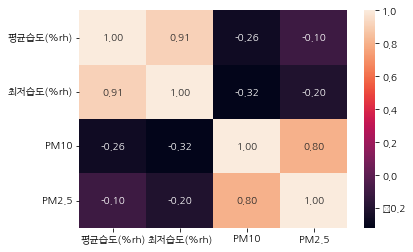

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')

sns.heatmap(data = df.corr(),
           annot = True,
           fmt = '.2f')

- 평균 습도를 기준으로, 둘 모두 약한 음의 상관관계를 보인다.

## 왜 Tableau에서 구한 거랑 다를까?

In [105]:
import scipy.stats as stats

print(stats.pearsonr(df['평균습도(%rh)'], df['PM10']))
print(stats.pearsonr(df['평균습도(%rh)'], df['PM2.5']))

(-0.2616081564444299, 3.9901337299466494e-07)
(-0.10288182238516726, 0.04952696667586136)


### 둘의 스케일이 달라서 그런 거 아닐까?
- 이를 수정하기 위해 PM10, PM2.5를 0과 100 사이로 스케일링함

In [119]:
df['scaled_PM10'] = (df['PM10'] - min(df['PM10'])) / (max(df['PM10']) - min(df['PM10'])) * 100
df['scaled_PM2.5'] = (df['PM2.5'] - min(df['PM2.5'])) / (max(df['PM2.5']) - min(df['PM2.5'])) * 100
df[['scaled_PM10', 'scaled_PM2.5']] = df[['scaled_PM10', 'scaled_PM2.5']].apply(lambda x : round(x, 1))
df.describe()

,평균습도(%rh),최저습도(%rh),PM10,PM2.5,scaled_PM10,scaled_PM2.5
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,64.510959,44.276712,32.780822,18.361644,15.096164,18.178356
std,13.719007,16.382872,19.071472,11.768166,10.365689,13.074665
min,31.500000,15.000000,5.000000,2.000000,0.000000,0.000000
25%,53.600000,32.000000,22.000000,10.000000,9.200000,8.900000
50%,64.400000,42.000000,29.000000,16.000000,13.000000,15.600000
75%,75.000000,55.000000,40.000000,23.000000,19.000000,23.300000
max,99.300000,97.000000,189.000000,92.000000,100.000000,100.000000


In [121]:
# 정규화한 피쳐에 피어슨 상관계수 & p-value를 구해도 동일한 값임을 확인할 수 있음
print(stats.pearsonr(df['평균습도(%rh)'], df['scaled_PM10']))
print(stats.pearsonr(df['평균습도(%rh)'], df['scaled_PM2.5']))

(-0.26166871110678225, 3.964720302322316e-07)
(-0.10308194496395774, 0.049083253074411366)


In [ ]:
df.to_csv('2022_hum_particle_ver2.csv')

## 값이 다른 이유 : R^2와 피어슨 상관계수는 다른 지표이기 때문
- 회귀식에서 나오는 R^2은 **결정 계수**라고 한다. 데이터의 변동량 중, 추세선으로 설명할 수 있는 부분의 비율을 나타낸다.
    - 그래서 **선형회귀식의 차수를 늘려줄 때마다 값이 변경된 것이다 : 회귀선이 바뀌었으니까**
- 1에 가까울수록 데이터를 잘 설명하는 모델이지만, 그렇다고 모델이 항상 완벽하다는 것은 아니다.

In [127]:
# 결정계수 구하기
from sklearn.linear_model import LinearRegression
import numpy as np
import statmodels.api as sm

# 인풋 x데이터는 2차원이어야 함
model = LinearRegression().fit(df['평균습도(%rh)'].to_numpy().reshape(-1, 1), df['scaled_PM10'])
r_sq = model.score(df['평균습도(%rh)'].to_numpy().reshape(-1, 1), df['scaled_PM10'])
print(r_sq)

model = LinearRegression().fit(df['평균습도(%rh)'].to_numpy().reshape(-1, 1), df['scaled_PM2.5'])
r_sq = model.score(df['평균습도(%rh)'].to_numpy().reshape(-1, 1), df['scaled_PM2.5'])
print(r_sq)

0.06847051437228446
0.010625887377552656


![image](image2.PNG)

- 위 태블로에서 파란 선은 PM2.5 : `R^2 = 0.0108985`
- 주황색 선은 PM10 : `R^2 = 0.0680269`

- 어쨌든 **결정계수 R^2은 회귀선이 데이터를 잘 설명해줄 수 있는가를 나타낸 값**이기 때문에, 이를 통해 회귀선의 형태를 바꾸면서 적절한 모델을 찾을 수는 있으나 이 결정계수 값 자체가 데이터를 설명한다고 보긴 어려울 것 같다.

## 결론
1. 습도와 미세먼지 계수 간의 상관관계는 약한 음의 관계를 나타내며, 초미세먼지가 특히 더 낮은 상관관계를 나타냄(-0.26 VS -0.10)
2. 여름에 습도가 올라가면서 미세먼지가 낮아지는 경향을 보인다. 

---
### 기타 지식
- 실제로 습도가 올라가면 물에 미세먼지들이 뭉치기 때문에 미세먼지 농도가 낮아지는 경향이 있다고 한다. 
- 공기 청정기와 가습기가 동시에 틀어지면, 공기 청정기는 가습기에 의해 나온 물 입자를 미세먼지로 인식해서 더 팡팡 돌아가고, 수분 입자가 공기 청정기의 수명에 좋지 않다고 하니 틀지 않는 것이 좋겠다.  

---
- 그 외에도, 중국에서 바람이 부는 계절은 대체로 건조한 편이고, 